# Classification of Sign Language with UCA-Net
## By Arda Mavi & Zeynep Dikle

### Summary:
Classification of our own 'Sign Language Dataset' with our own machine learning algorithm 'UCA-Net'

### Connecting Drive:

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import sys
sys.path.insert(0, 'drive/Colab_UCA-Net')

In [4]:
!ls drive/Colab_UCA-Net

Classification-of-Sign-Language-with-UCA-Net.ipynb  __pycache__
Data						    README.md
get_dataset.py					    requirements.txt
LICENSE


In [5]:
!pip3 install -r drive/Colab_UCA-Net/requirements.txt

    100% |████████████████████████████████| 327kB 2.1MB/s 


In [6]:
# Import
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Getting Dataset:
from get_dataset import get_dataset
X_train, X_test, Y_train, Y_test = get_dataset('drive/Colab_UCA-Net/Data/npy_dataset')

Training shape: (1649, 64, 64, 1)
1649 sample, 64 x 64 size grayscale image.

Test shape: (413, 64, 64, 1)
413 sample, 64 x 64 size grayscale image.

Examples:


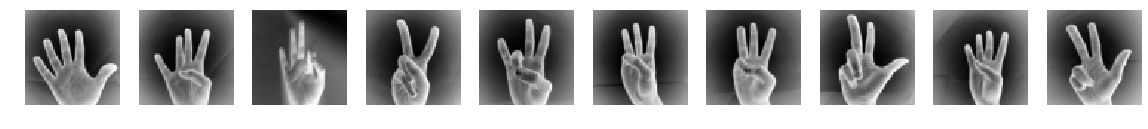

In [8]:
# About Dataset:

img_size = X_train.shape[1] # 64
channel_size = X_train.shape[3] # 1: Grayscale, 3: RGB

print('Training shape:', X_train.shape)
print(X_train.shape[0], 'sample,',X_train.shape[1] ,'x',X_train.shape[2] ,'size grayscale image.\n')
print('Test shape:', X_test.shape)
print(X_test.shape[0], 'sample,',X_test.shape[1] ,'x',X_test.shape[2] ,'size grayscale image.\n')

print('Examples:')
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # Display some data:
    ax = plt.subplot(1, n, i)
    plt.imshow(X_train[i].reshape(img_size, img_size))
    plt.gray()
    plt.axis('off')

# Creating Model:

In [9]:
# Deep Learning Model:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Activation, Lambda, Flatten, concatenate, Reshape
from keras.models import Model

input_img = Input(shape=(img_size, img_size, channel_size))

layer_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
layer_1 = MaxPooling2D((2, 2))(layer_1)

layer_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(layer_1)
layer_2 = MaxPooling2D((2, 2))(layer_2)

layer_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(layer_2)
layer_3 = MaxPooling2D((2, 2))(layer_3)

flat_1 = Flatten()(layer_3)

fc_1 = Dense(256)(flat_1)
fc_1 = Activation('relu')(fc_1)

fc_2 = Dense(128)(fc_1)
fc_2 = Activation('relu')(fc_2)

#Decoder:

fc_3 = Dense(256)(fc_2)
fc_3 = Activation('relu')(fc_3)

fc_4 = Dense(16384)(fc_3)
fc_4 = Activation('relu')(fc_4)

reshape_1 = Reshape((8, 8, 256))(fc_4)

layer_4 = UpSampling2D((2, 2))(reshape_1)
layer_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(layer_4)

layer_5 = UpSampling2D((2, 2))(layer_4)
layer_5 = Conv2D(128, (3, 3), activation='relu', padding='same')(layer_5)

layer_6 = UpSampling2D((2, 2))(layer_5)
layer_6 = Conv2D(64, (3, 3), activation='relu', padding='same')(layer_6)

layer_7 = Conv2D(channel_size, (3, 3), activation='sigmoid', padding='same')(layer_6)

autoencoder = Model(input_img, layer_7)
autoencoder.compile(optimizer='rmsprop', loss='mse')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         
__________

In [0]:
# Checkpoints:
from keras.callbacks import ModelCheckpoint, TensorBoard
checkpoints = []
#checkpoints.append(TensorBoard(log_dir='/Checkpoints/logs'))

#### For training model with Data Augmentation run this cell:

# Creates live data:
# For better yield. The duration of the training is extended.

from keras.preprocessing.image import ImageDataGenerator
generated_data = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, rotation_range=0,  width_shift_range=0.1, height_shift_range=0.1, horizontal_flip = True, vertical_flip = False)
generated_data.fit(X_train)

model.fit_generator(generated_data.flow(X_train, X_train, batch_size=batch_size), steps_per_epoch=X.shape[0], epochs=epochs, validation_data=(X_test, X_test), callbacks=checkpoints)

In [0]:
# Getting saved mode:

autoencoder.load_weights('drive/Colab_UCA-Net/Data/Model/weights.h5')

# Training Model:
epochs = 20
batch_size = 5
autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, X_test), shuffle=True, callbacks=checkpoints)

# Save Model and weights:

import os
def save_model(model):
    if not os.path.exists('Data/Model/'):
        os.makedirs('Data/Model/')
    model_json = model.to_json()
    with open("Data/Model/model.json", "w") as model_file:
        model_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("Data/Model/weights.h5")
    print('Model and weights saved')
    return
save_model(autoencoder)

In [0]:
decoded_imgs = autoencoder.predict(X_test[0:11])

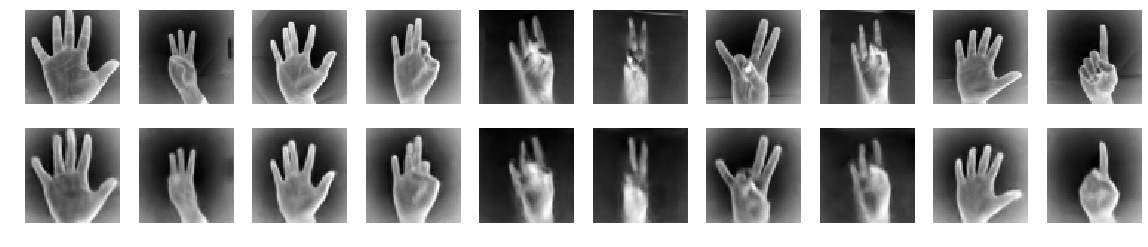

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(64, 64))
    plt.gray()
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64))
    plt.gray()
    plt.axis('off')

In [14]:
# Split autoencoder:
encoder = Model(input_img, fc_2)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         
__________

In [0]:
num_summary = 128

In [16]:
# Deep Learning Model:
from keras.layers import Input, Dense, Activation, Dropout
from keras.models import Model

sn_inputs = Input(shape=(2*num_summary,))

sn_fc_1 = Dense(512)(sn_inputs)
sn_fc_1 = Activation('relu')(sn_fc_1)

sn_drp_1 = Dropout(0.2)(sn_fc_1)

sn_fc_2 = Dense(256)(sn_drp_1)
sn_fc_2 = Activation('relu')(sn_fc_2)

sn_drp_2 = Dropout(0.2)(sn_fc_2)

sn_fc_3 = Dense(64)(sn_drp_2)
sn_fc_3 = Activation('relu')(sn_fc_3)

sn_fc_4 = Dense(1)(sn_fc_3)
sn_similarity_output = Activation('sigmoid')(sn_fc_4)

similarity_net = Model(sn_inputs, sn_similarity_output)
similarity_net.compile(optimizer='adadelta', loss='mse')

similarity_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [17]:
from keras.layers import Input, concatenate

encoder.trainable = False

dis_input_img = Input(shape=(img_size, img_size, channel_size))
dis_encoder_out = encoder(dis_input_img)

dis_input_img_2 = Input(shape=(img_size, img_size, channel_size))
dis_encoder_out_2 = encoder(dis_input_img_2)

dis_cont_1 = concatenate([dis_encoder_out, dis_encoder_out_2])

dis_output = similarity_net(dis_cont_1)
discriminator = Model([dis_input_img, dis_input_img_2], dis_output)
discriminator.compile(optimizer='adadelta', loss='mse', metrics=['accuracy'])
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 128)          4597120     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256)          0           model_2[1][0]                    
          

In [18]:
X_train_sets = []
X_train_sets_2 = []
Y_train_sets = []

for k in range(0, 5):
    for i in range(0, X_train.shape[0]):
        X_train_sets.append(X_train[i])
        same_y_indexs = [index for index, same_Ys in enumerate((np.argmax(Y_train[i]) == np.argmax(Y_train, axis=1)).tolist()) if same_Ys]
        same_y_img = X_train[same_y_indexs[np.random.randint(len(same_y_indexs), size=1)[0]]]
        X_train_sets_2.append(same_y_img)
        Y_train_sets.append(1)


        X_train_sets.append(X_train[i])
        not_same_y_indexs = [index for index, not_same_Ys in enumerate((np.argmax(Y_train[i]) != np.argmax(Y_train, axis=1)).tolist()) if not_same_Ys]
        not_same_y_img = X_train[not_same_y_indexs[np.random.randint(len(not_same_y_indexs), size=1)[0]]]
        X_train_sets_2.append(not_same_y_img)
        Y_train_sets.append(0)


X_train_sets = np.array(X_train_sets)
X_train_sets_2 = np.array(X_train_sets_2)
Y_train_sets = np.array(Y_train_sets).reshape(len(Y_train_sets), 1)

print(X_train_sets.shape, X_train_sets_2.shape)
print(Y_train_sets.shape)

(16490, 64, 64, 1) (16490, 64, 64, 1)
(16490, 1)


Index: 750


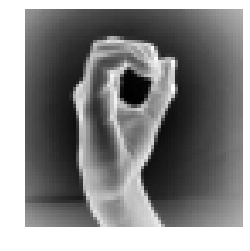

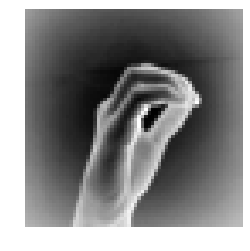

[1]
Index: 751


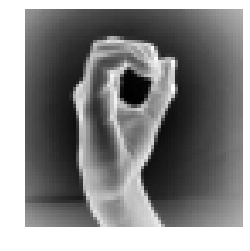

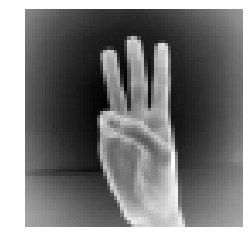

[0]


In [19]:
# Example:

indx = np.random.randint(len(X_train_sets), size=1)[0]

print('Index:', indx)

plt.gray()
plt.imshow(X_train_sets[indx].reshape(img_size, img_size))
plt.axis('off')
plt.show()
plt.gray()
plt.imshow(X_train_sets_2[indx].reshape(img_size, img_size))
plt.axis('off')
plt.show()
print(Y_train_sets[indx])

print('Index:', indx+1)
plt.gray()
plt.imshow(X_train_sets[indx+1].reshape(img_size, img_size))
plt.axis('off')
plt.show()
plt.gray()
plt.imshow(X_train_sets_2[indx+1].reshape(img_size, img_size))
plt.axis('off')
plt.show()
print(Y_train_sets[indx+1])

# Getting saved mode:

In [0]:
discriminator.load_weights('drive/Colab_UCA-Net/Data/Model/weights_discriminator.h5')

In [0]:
# epochs = 30
# discriminator.fit([X_train_sets, X_train_sets_2], Y_train_sets, batch_size=6, epochs=epochs, shuffle=True, validation_split=0.2)

TODO:
1) Update "discriminator" model
2) Fix the places under (For "discriminator" model as output shape with 2)

# Save weights:

import os
def save_model(model):
    if not os.path.exists('drive/Colab_UCA-Net/Data/Model/'):
        os.makedirs('drive/Colab_UCA-Net/Data/Model/')
    model_json = model.to_json()
    with open("drive/Colab_UCA-Net/Data/Model/model_discriminator.json", "w") as model_file:
        model_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("drive/Colab_UCA-Net/Data/Model/weights_discriminator.h5")
    print('Weights saved')
    return
save_model(discriminator)

In [35]:
# Save weights:

import os
def save_model(model):
    # serialize weights to HDF5
    model.save_weights("drive/Colab_UCA-Net/Data/Model/weights_discriminator.h5")
    print('Weights saved')
    return
save_model(discriminator)

Weights saved


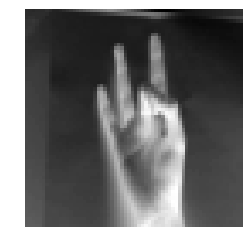

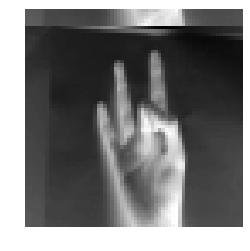

0.9950742


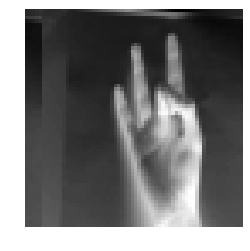

0.3336078


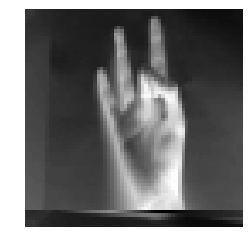

0.6344813


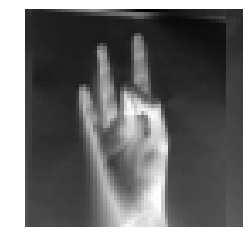

0.28198415


In [36]:
index = 8
one_simple = X_test[index].reshape(1, img_size, img_size, channel_size)

plt.gray()
plt.imshow(one_simple.reshape(img_size, img_size))
plt.axis('off')
plt.show()

shift = 5
for i in [shift, -1*shift,]:
    for j in [1, 2]:
        noise_img = np.roll(one_simple, i, axis=j)

        plt.imshow(noise_img.reshape(img_size, img_size))
        plt.axis('off')
        plt.show()

        print(discriminator.predict([one_simple, noise_img])[0][0])

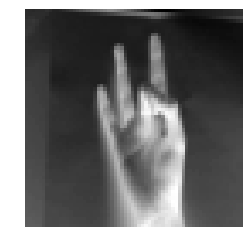

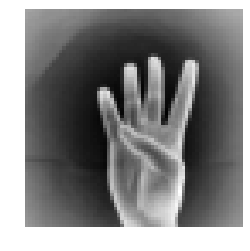

0.2240121


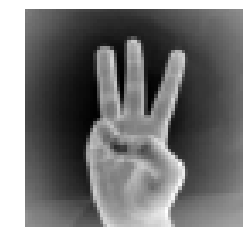

0.040184416


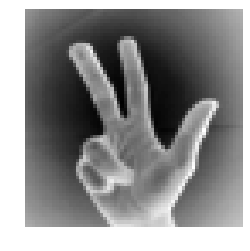

0.00094576314


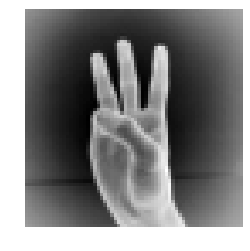

0.19353846


In [37]:
plt.gray()
index = 8
one_simple = X_test[index].reshape(1, img_size, img_size, channel_size)

plt.gray()
plt.imshow(one_simple.reshape(img_size, img_size))
plt.axis('off')
plt.show()

for i in [1,2]:
    for j in [1,-1]:
        noise_image = X_train[index + j*i].reshape(1, img_size, img_size, 1)

        plt.imshow(noise_image.reshape(img_size, img_size))
        plt.axis('off')
        plt.show()

        print(discriminator.predict([one_simple, noise_image])[0][0])

### Now we look up result:

0.818574


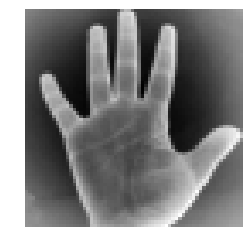

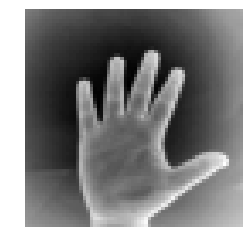

0.002596543


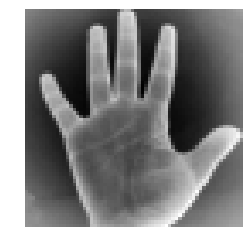

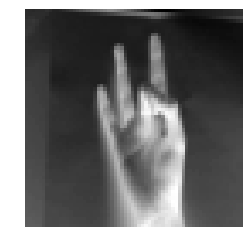

In [38]:
print(discriminator.predict([X_test[1].reshape(1,64,64,1), X_test[9].reshape(1,64,64,1)])[0][0])

plt.axis('off')
plt.imshow(X_test[1].reshape(64, 64))
plt.show()

plt.axis('off')
plt.imshow(X_test[9].reshape(64, 64))
plt.show()

print(discriminator.predict([X_test[1].reshape(1,64,64,1), X_test[8].reshape(1,64,64,1)])[0][0])

plt.axis('off')
plt.imshow(X_test[1].reshape(64, 64))
plt.show()

plt.axis('off')
plt.imshow(X_test[8].reshape(64, 64))
plt.show()

# Classifiction:

0:


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


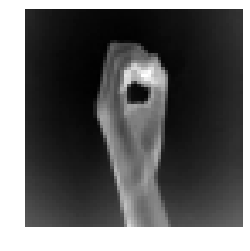

1:


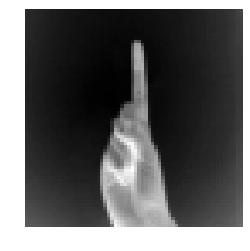

2:


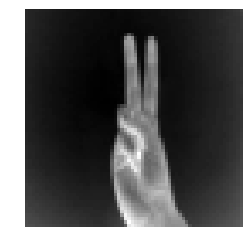

3:


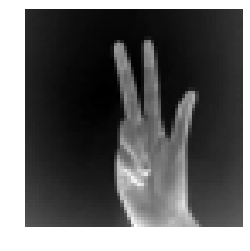

4:


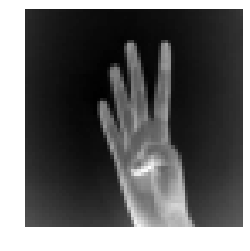

5:


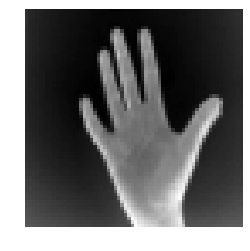

6:


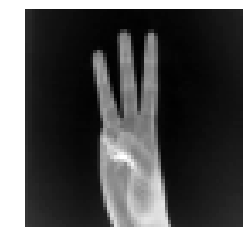

7:


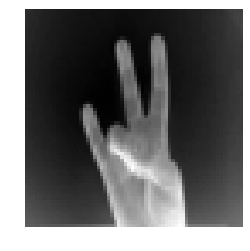

8:


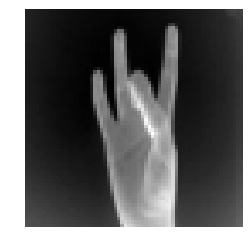

9:


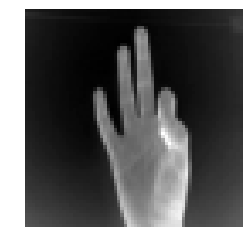

In [39]:
from os import listdir
from get_dataset import get_img

dataset_path = 'drive/Colab_UCA-Net/Data/Train_Data'

data_samples = []

labels = listdir(dataset_path)
for label in range(0,10):
    datas_path = dataset_path+'/{0}'.format(label)
    img = get_img(datas_path+'/'+listdir(datas_path)[0])
    data_samples.append(img)
data_samples = 1 - np.array(data_samples).astype('float32')/255.
data_samples = data_samples.reshape(data_samples.shape[0], img_size, img_size, channel_size)

for i, img in enumerate(data_samples):
    print('{0}:'.format(i))
    plt.gray()
    plt.imshow(img.reshape(img_size, img_size))
    plt.axis('off')
    plt.show()

In [0]:
class_code = encoder.predict(data_samples)

# Accuracy:

In [0]:
encode = encoder.predict(X_test)

In [0]:
models_y_test = []
for i in encode:
    results = []
    for j in class_code:
        sim_y = similarity_net.predict(np.concatenate((i, j), axis=0).reshape(1, 256))
        results.append(sim_y[0][0])
    models_y_test.append(np.argmax(np.array(results).reshape(10), axis=0))
    
models_y_test = np.array(models_y_test)

Loss: 0.16464891041162233
Examples:


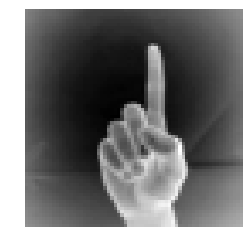

Class: 1 - Model's Output Class: 1 

 ----------------------------------------


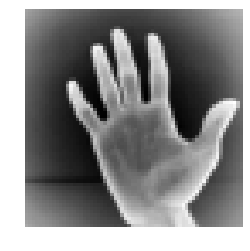

Class: 5 - Model's Output Class: 5 

 ----------------------------------------


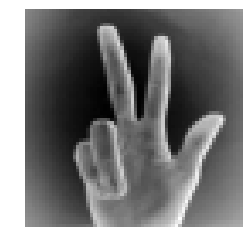

Class: 3 - Model's Output Class: 3 

 ----------------------------------------


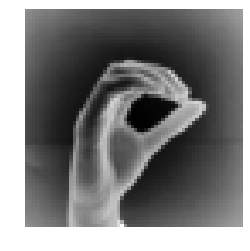

Class: 0 - Model's Output Class: 0 

 ----------------------------------------


In [43]:
num_Y_test = np.argmax(Y_test, axis=1)

comparison = models_y_test == num_Y_test
loss = 1 - np.sum(comparison.astype(int)) / num_Y_test.shape[0]

print('Loss:', loss)
print('Examples:')
for i in range(10,14):
    plt.imshow(X_test[i].reshape(64, 64))
    plt.gray()
    plt.axis('off')
    plt.show()
    print('Class:',  num_Y_test[i], '- Model\'s Output Class:', models_y_test[i],'\n'*2,'-'*40)

### Thank you!
#### Still in development